In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

from keras.models import Sequential, Model
from keras import models
from keras import layers
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

import tqdm as tqdm
import pandas_profiling



Using TensorFlow backend.


In [2]:
# add .png extension to photo_id; separate attributes
train_df = pd.read_csv("train_.csv")
train_df["attribute_ids"] = train_df["attribute_ids"].apply(lambda x: x.split(" "))
train_df["photo_id"] = train_df["photo_id"].apply(lambda x: x+".png")
print(f"there are {train_df.shape[0]} images")
train_df.head()

there are 109237 images


,photo_id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


In [20]:
def create_fileToAttribute_mapping(train_df):
    mapping = dict()
    for i in range(len(train_df)):
        photo_id, attribute_ids = train_df['photo_id'][i], train_df['attribute_ids'][i]
        mapping[photo_id] = attribute_ids 
    return mapping

In [21]:
create_fileToAttribute_mapping(train_df)

{'1000483014d91860.png': ['147', '616', '813'],
 '1000fe2e667721fe.png': ['51', '616', '734', '813'],
 '1001614cb89646ee.png': ['776'],
 '10041eb49b297c08.png': ['51', '671', '698', '813', '1092'],
 '100501c227f8beea.png': ['13', '404', '492', '903', '1093'],
 '10050ed12fbad46d.png': ['189', '279', '774', '800', '1051'],
 '100543a032517972.png': ['188', '1034'],
 '1006665c0aad488.png': ['1010', '1053'],
 '1007057734dba6df.png': ['189', '541', '542', '993'],
 '1008abd71f3ed5bc.png': ['70', '776', '794', '813', '1046', '1092'],
 '1008c7837081f985.png': ['79', '1062'],
 '1009f5737fc77f2.png': ['188', '668', '754'],
 '100a0dcde728cb36.png': ['51', '675'],
 '100a58282c6584bf.png': ['147', '716', '903', '1092'],
 '100b45b7c4020f5d.png': ['161', '489', '704', '1100'],
 '100bb499d37d0751.png': ['188', '535'],
 '100bbf5e832083d3.png': ['51', '212', '426', '586', '940'],
 '100d750286e85bf3.png': ['13', '616'],
 '100e1e65a6d7850e.png': ['737', '1009', '1046'],
 '100ef61c00e1b5d3.png': ['25', '161

In [3]:
label_df = pd.read_csv("labels.csv")
print(f"there are {label_df.shape[0]} attributes")
label_df[:5]

there are 1103 attributes


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [4]:
labels_sorted = label_df.sort_index(1, 'attribute_name' )   
labels_sorted.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [5]:
labels_dict = {label_df['attribute_name'][i]:i for i in range(len(label_df))}
labels_dict

{'culture::abruzzi': 0,
 'culture::achaemenid': 1,
 'culture::aegean': 2,
 'culture::afghan': 3,
 'culture::after british': 4,
 'culture::after german': 5,
 'culture::after german original': 6,
 'culture::after italian': 7,
 'culture::after russian original': 8,
 'culture::akkadian': 9,
 'culture::alexandria-hadra': 10,
 'culture::algerian': 11,
 'culture::alsace': 12,
 'culture::american': 13,
 'culture::american or european': 14,
 'culture::amsterdam': 15,
 'culture::ansbach': 16,
 'culture::antwerp': 17,
 'culture::apulian': 18,
 'culture::arabian': 19,
 'culture::aragon': 20,
 'culture::arica': 21,
 'culture::asia minor': 22,
 'culture::assyrian': 23,
 'culture::atlantic watershed': 24,
 'culture::attic': 25,
 'culture::augsburg': 26,
 'culture::augsburg decoration': 27,
 'culture::augsburg original': 28,
 'culture::austrian': 29,
 'culture::avignon': 30,
 'culture::avon': 31,
 'culture::aztec': 32,
 'culture::babylonian': 33,
 'culture::babylonian or kassite': 34,
 'culture::bactr

In [6]:
inverse_labels_dict = {i:label_df['attribute_name'][i] for i in range(len(label_df))}
inverse_labels_dict

{0: 'culture::abruzzi',
 1: 'culture::achaemenid',
 2: 'culture::aegean',
 3: 'culture::afghan',
 4: 'culture::after british',
 5: 'culture::after german',
 6: 'culture::after german original',
 7: 'culture::after italian',
 8: 'culture::after russian original',
 9: 'culture::akkadian',
 10: 'culture::alexandria-hadra',
 11: 'culture::algerian',
 12: 'culture::alsace',
 13: 'culture::american',
 14: 'culture::american or european',
 15: 'culture::amsterdam',
 16: 'culture::ansbach',
 17: 'culture::antwerp',
 18: 'culture::apulian',
 19: 'culture::arabian',
 20: 'culture::aragon',
 21: 'culture::arica',
 22: 'culture::asia minor',
 23: 'culture::assyrian',
 24: 'culture::atlantic watershed',
 25: 'culture::attic',
 26: 'culture::augsburg',
 27: 'culture::augsburg decoration',
 28: 'culture::augsburg original',
 29: 'culture::austrian',
 30: 'culture::avignon',
 31: 'culture::avon',
 32: 'culture::aztec',
 33: 'culture::babylonian',
 34: 'culture::babylonian or kassite',
 35: 'culture::b

In [7]:
pandas_profiling.ProfileReport(label_df)

In [8]:
print(os.listdir('train')[0:5])

['1000483014d91860.png', '1000fe2e667721fe.png', '1001614cb89646ee.png', '10041eb49b297c08.png', '100501c227f8beea.png']


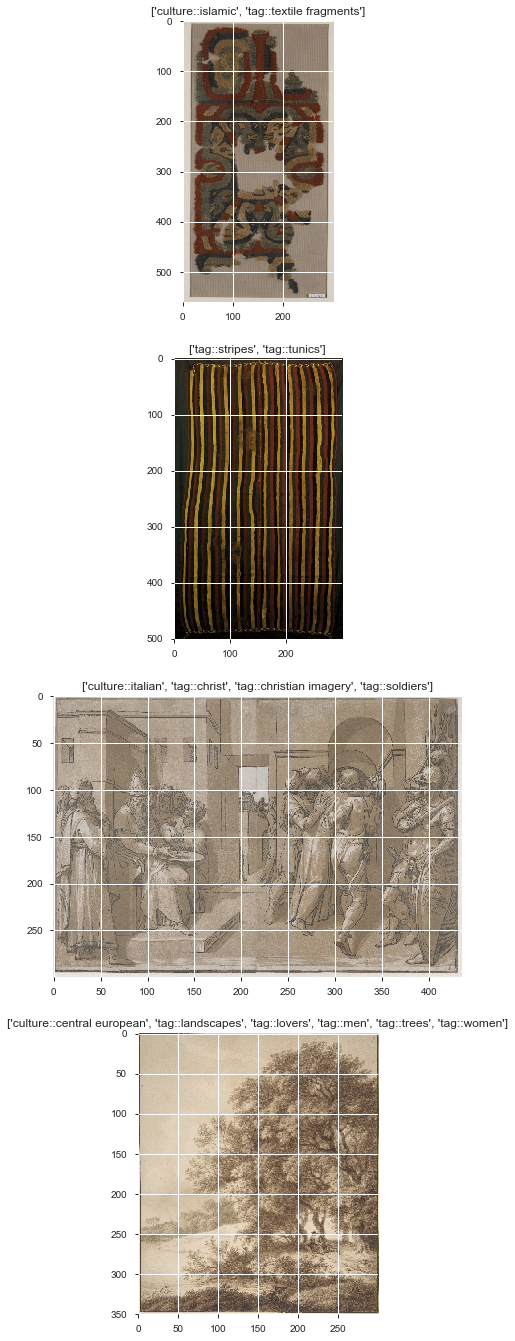

In [24]:
i = 1
plt.figure(figsize=[30,30])
for img_name in os.listdir("train")[6:10]:   
    img = cv2.imread("train/%s" % img_name)[...,[2, 1, 0]] #i think train/%s is saying to convert the path names into strings
                                                           # so that cv2.imread can read the photos (https://docs.python.org/3/
                                                           #library/stdtypes.html#printf-style-string-formatting)
    plt.subplot(5, 1, i)
    plt.imshow(img)
    ids = train_df[train_df["photo_id"] == img_name]["attribute_ids"]
    title_val = []
    for tag_id in ids.values[0]:
        att_name = label_df[label_df['attribute_id'].astype(str) == tag_id]['attribute_name'].values[0]
        title_val.append(att_name)
    plt.title(title_val)
    i += 1
    
plt.show()

##### create in memory dataset